In [81]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib
plt.style.use('figures.mplstyle')
import leptoninjector as LI
from MuonSimulationHelpers import *
from GeometryHelpers import xyz_to_lat_long

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


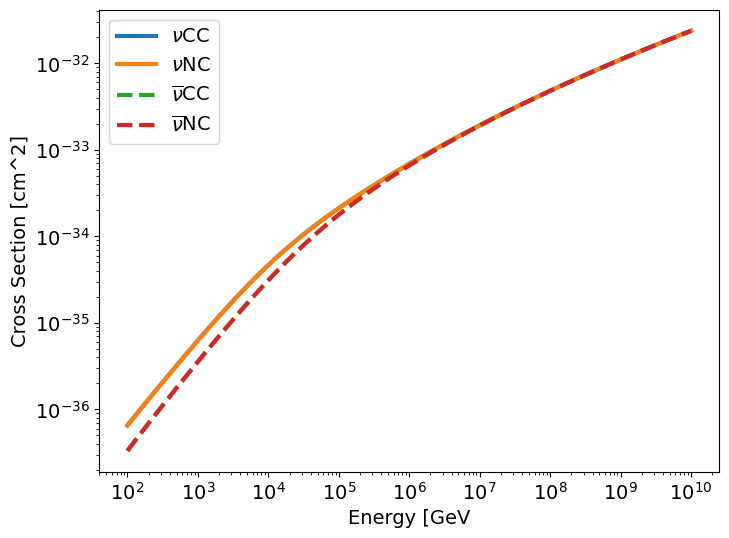

In [82]:
Erange = np.logspace(2,10,100)
for k in DIS_xs:
    if 'bar' in k:
        xs = np.array([DIS_xs[k].TotalCrossSection(numubar,E,target_type) for E in Erange])
        plt.plot(Erange,xs,label=r'$\overline{\nu}$' + k[-2:],ls='--')
#         for primary,tag in zip([nuebar,numubar,nutaubar],
#                                [r'$\overline{\nu}_e$',r'$\overline{\nu}_\mu$',r'$\overline{\nu}_\tau$']):
            
#             xs = np.array([DIS_xs[k].TotalCrossSection(primary,E,target_type) for E in Erange])
#             plt.plot(Erange,xs,label=tag + k[-2:],ls='--')
    else:
        xs = np.array([DIS_xs[k].TotalCrossSection(numu,E,target_type) for E in Erange])
        plt.plot(Erange,xs,label=r'$\nu$' + k[-2:])
#         for primary,tag in zip([nue,numu,nutau],
#                                [r'$\nu_e$',r'${\nu}_\mu$',r'${\nu}_\tau$']):
            
#             xs = np.array([DIS_xs[k].TotalCrossSection(primary,E,target_type) for E in Erange])
#             plt.plot(Erange,xs,label=tag + k[-2:])
plt.loglog()
plt.legend()
plt.xlabel('Energy [GeV')
plt.ylabel('Cross Section [cm^2]')
plt.show()

In [92]:
light_simulation = MuonSimulation('Data/MuonSimulation/Large_EPOSLHC_light.parquet')
charm_simulation = MuonSimulation('Data/MuonSimulation/Large_BKRS_charm.parquet')
N = 20000
# light_simulation.SampleSecondaryMomenta(N)
# light_simulation.CalculateLakeIntersectionsFromIP('LHCb',N)
# light_simulation.CalculateSurfaceIntersectionFromIP('LHCb',N)
# light_simulation.CalculateDISlocationFromIP('LHCb',N=N)
# light_simulation.DumpData('Data/MuonSimulation/Large_EPOSLHC_light.parquet')
# charm_simulation.SampleSecondaryMomenta(N)
# charm_simulation.CalculateLakeIntersectionsFromIP('LHCb',N)
# charm_simulation.CalculateSurfaceIntersectionFromIP('LHCb',N)
# charm_simulation.CalculateDISlocationFromIP('LHCb',N=N)
# charm_simulation.DumpData('Data/MuonSimulation/Large_BKRS_charm.parquet')

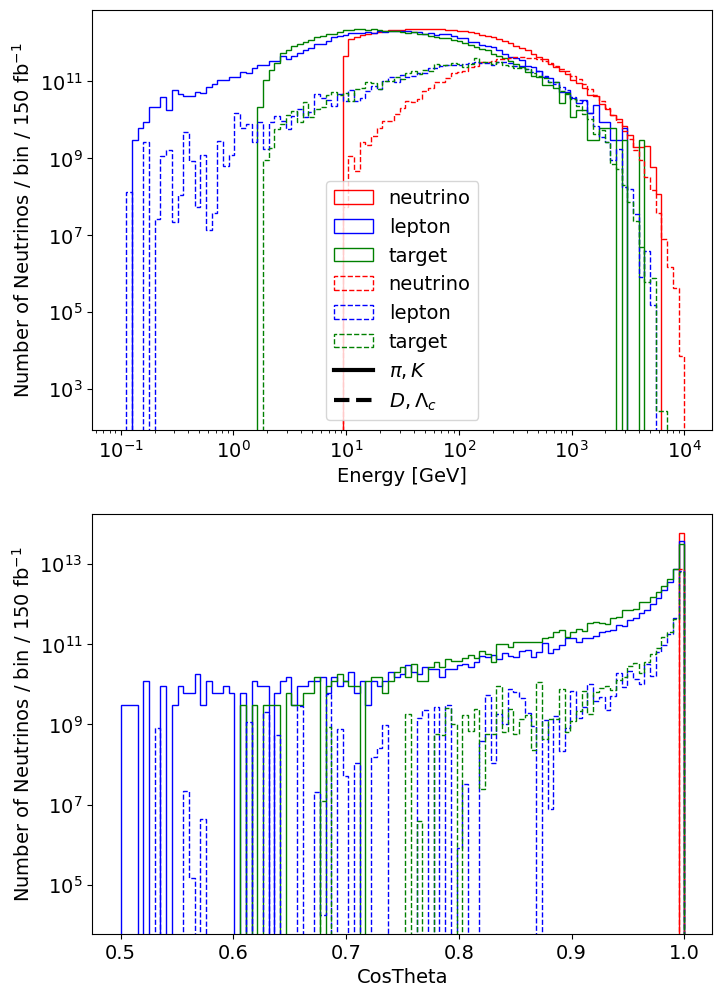

In [93]:
ls_arr = ['solid','dashed']
fig,ax = plt.subplots(2,1,figsize=(8,12))
for i,simulation in enumerate([light_simulation,charm_simulation]):
    
    simulation.EnsureUnitHadDir()
    simulation.EnsureUnitLepDir()
    simulation.EnsureUnitNeutrinoDir()
    
    
    kwargs = {'bins':np.logspace(-1,4,100),
              'histtype':'step',
              'ls':ls_arr[i],
              'weights':simulation.data['wgt']*150*1000}

    ax[0].hist(simulation.data['E'],color='r',label='neutrino',**kwargs)
    wnorm = sum(kwargs['weights'])/sum(simulation.data.query('E_lep>0')['wgt']*150*1000)
    kwargs['weights']*=wnorm
    ax[0].hist(simulation.data['E_lep'],color='b',label='lepton',**kwargs)
    ax[0].hist(simulation.data['E_had'],color='g',label='target',**kwargs)
    
    kwargs = {'bins':np.linspace(0.5,1,100),
              'histtype':'step',
              'ls':ls_arr[i],
              'weights':simulation.data['wgt']*150*1000}
    
    ax[1].hist(simulation.data['uz'],color='r',**kwargs)
    wnorm = sum(kwargs['weights'])/sum(simulation.data.query('E_lep>0')['wgt']*150*1000)
    kwargs['weights']*=wnorm
    ax[1].hist(simulation.data['uz_lep'],color='b',**kwargs)
    ax[1].hist(simulation.data['uz_had'],color='g',**kwargs)

ax[0].plot([],[],color='black',label=r'$\pi,K$')
ax[0].plot([],[],color='black',ls='--',label=r'$D,\Lambda_c$')
ax[0].set_xlabel('Energy [GeV]')
ax[0].set_ylabel(r'Number of Neutrinos / bin / 150 fb$^{-1}$')
ax[0].loglog()
ax[0].legend()

ax[1].set_xlabel('CosTheta')
ax[1].set_ylabel(r'Number of Neutrinos / bin / 150 fb$^{-1}$')
ax[1].semilogy()

plt.show()

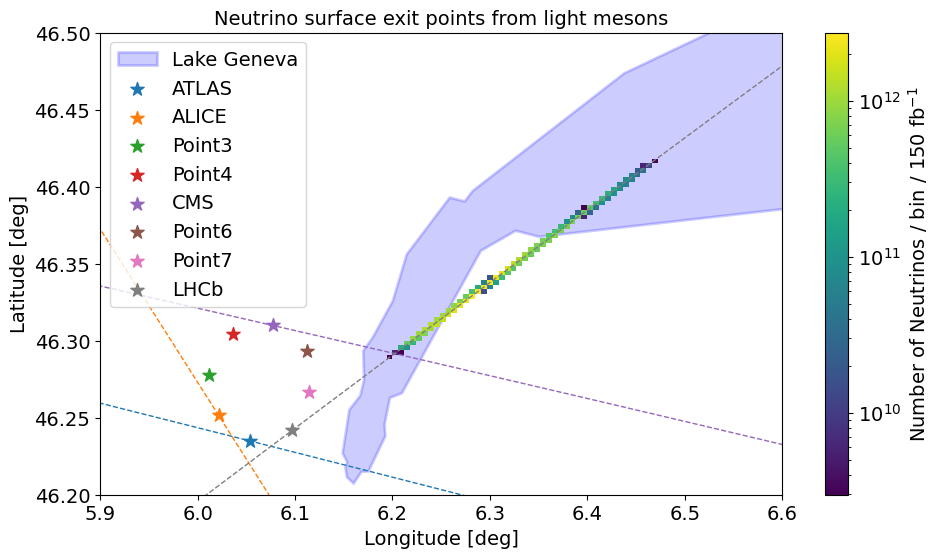

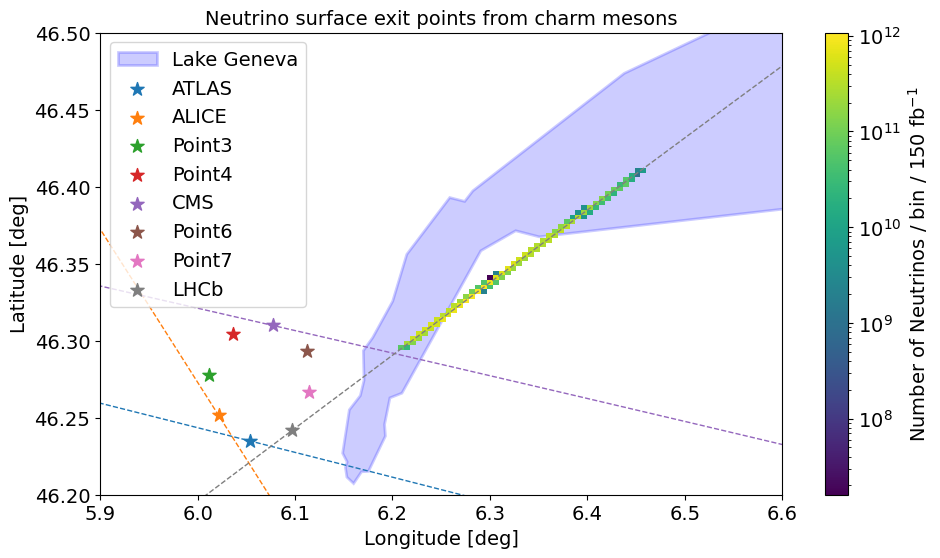

In [94]:
for simulation,tag in zip([light_simulation,charm_simulation],
                          ['light','charm']):
    fig = plt.figure(figsize=(11,6))
    plt.fill(list(Lake_data['Longitude']) + [Lake_data['Longitude'][0]],
             list(Lake_data['Latitude']) + [Lake_data['Latitude'][0]],
             color='blue',label='Lake Geneva',alpha=0.2,linewidth=2)
    for k,color in zip(list(LHC_data.index),mcolors.TABLEAU_COLORS):
        lines = plot_tangent_line_lat_long(LHC,
                                           np.array(LHC_data.loc[k,['X','Y','Z']]),
                                           np.array(LHC_data.loc[k,['CrossingOrientation','CrossingAngle']]),
                                           limit=1 if 'Point' in k else 60000)
        center, earth_points = lines[0] # all lines are essentially the same
        plt.plot([p[1] for p in earth_points],
                [p[0] for p in earth_points],color=color,ls='--',lw=1)
        plt.scatter(center[1],
                    center[0],
                    marker='*',color=color,label=k)
        if 'Point' in k: continue # don't consider points without collisions
        int1,int2 = calculate_intersections_with_lake(LHC,
                                                    np.array(LHC_data.loc[k,['X','Y','Z']]),
                                                    np.array(LHC_data.loc[k,['CrossingOrientation','CrossingAngle']]),
                                                    np.array(Lake_data[['Latitude','Longitude']]),
                                                    limit=50000000)
    plt.xlabel('Longitude [deg]')
    plt.ylabel('Latitude [deg]')
    plt.legend(loc='upper left')
    plt.title('Neutrino surface exit points from %s mesons'%tag,fontsize=14)
    plt.hist2d([x[1] for x in simulation.data['surface_intersection_lat_long'][:N]],
               [x[0] for x in simulation.data['surface_intersection_lat_long'][:N]],
               bins=(np.linspace(6.0,6.6,100),np.linspace(46.2,46.5,100)),
               weights = (simulation.data['wgt']*150*1000)[:N]*len(simulation.data)/N,
               norm=matplotlib.colors.LogNorm())
    c = plt.colorbar()
    c.set_label(r'Number of Neutrinos / bin / 150 fb$^{-1}$')
    plt.xlim(5.9,6.6)
    plt.ylim(46.2,46.5)
    plt.show()


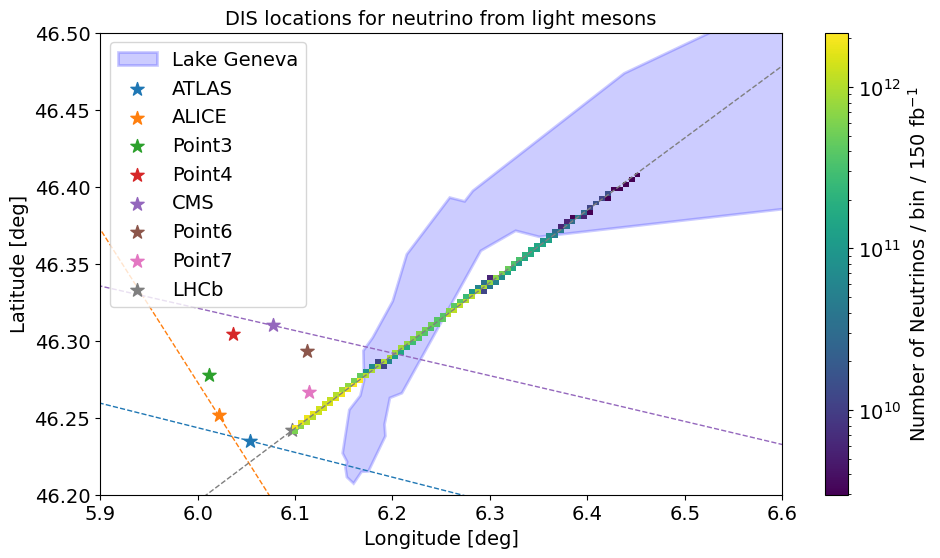

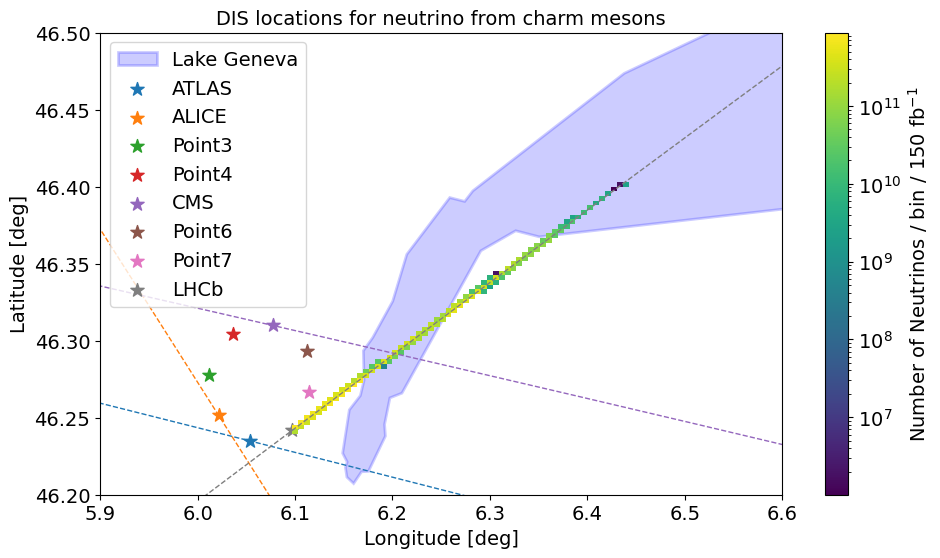

In [95]:
for simulation,tag in zip([light_simulation,charm_simulation],
                          ['light','charm']):
    fig = plt.figure(figsize=(11,6))
    plt.fill(list(Lake_data['Longitude']) + [Lake_data['Longitude'][0]],
             list(Lake_data['Latitude']) + [Lake_data['Latitude'][0]],
             color='blue',label='Lake Geneva',alpha=0.2,linewidth=2)
    for k,color in zip(list(LHC_data.index),mcolors.TABLEAU_COLORS):
        lines = plot_tangent_line_lat_long(LHC,
                                           np.array(LHC_data.loc[k,['X','Y','Z']]),
                                           np.array(LHC_data.loc[k,['CrossingOrientation','CrossingAngle']]),
                                           limit=1 if 'Point' in k else 60000)
        center, earth_points = lines[0] # all lines are essentially the same
        plt.plot([p[1] for p in earth_points],
                [p[0] for p in earth_points],color=color,ls='--',lw=1)
        plt.scatter(center[1],
                    center[0],
                    marker='*',color=color,label=k)
        if 'Point' in k: continue # don't consider points without collisions
        int1,int2 = calculate_intersections_with_lake(LHC,
                                                    np.array(LHC_data.loc[k,['X','Y','Z']]),
                                                    np.array(LHC_data.loc[k,['CrossingOrientation','CrossingAngle']]),
                                                    np.array(Lake_data[['Latitude','Longitude']]),
                                                    limit=50000000)
    plt.xlabel('Longitude [deg]')
    plt.ylabel('Latitude [deg]')
    plt.legend(loc='upper left')
    plt.title('DIS locations for neutrino from %s mesons'%tag,fontsize=14)
    plt.hist2d([xyz_to_lat_long(*x)[1] for x in simulation.data['DIS_location'][:N]],
               [xyz_to_lat_long(*x)[0] for x in simulation.data['DIS_location'][:N]],
               bins=(np.linspace(6.0,6.6,100),np.linspace(46.2,46.5,100)),
               weights = (simulation.data['wgt']*150*1000)[:N]*len(simulation.data)/N,
               norm=matplotlib.colors.LogNorm())
    c = plt.colorbar()
    c.set_label(r'Number of Neutrinos / bin / 150 fb$^{-1}$')
    plt.xlim(5.9,6.6)
    plt.ylim(46.2,46.5)
    plt.show()

In [96]:
profile_nu = light_simulation.CalculateNeutrinoProfileFromIP('LHCb',N=N)
profile_mu = light_simulation.CalculateMuonProfileFromIP('LHCb',N=N)

18210.36420728398
18210.36420728398


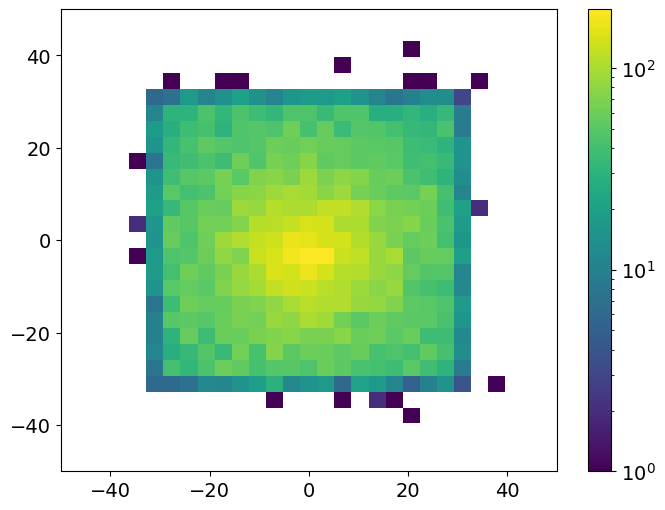

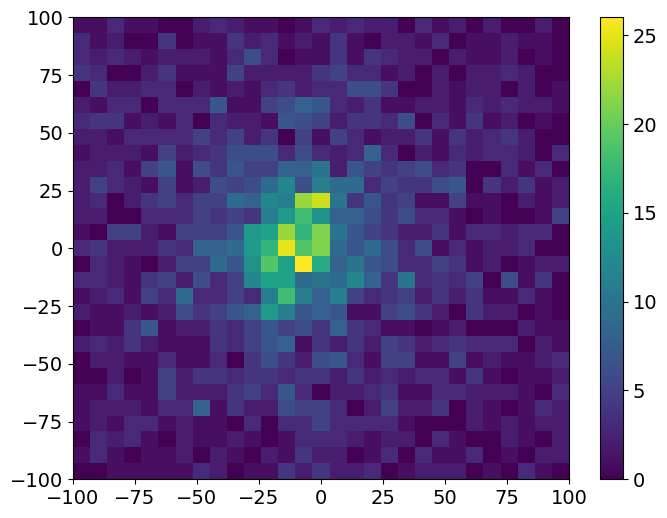

In [100]:
plt.hist2d(profile_nu[:,0],profile_nu[:,1],bins=np.linspace(-50,50,30),norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.show()

plt.hist2d(profile_mu[:,0],profile_mu[:,1],bins=np.linspace(-100,100,30))#,norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.show()

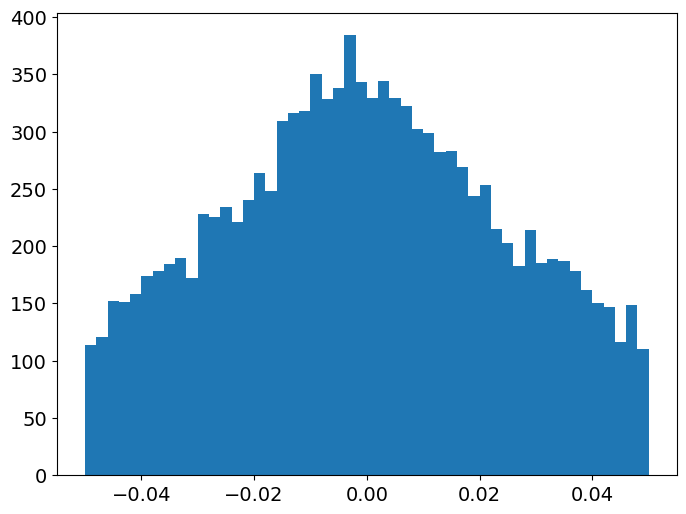

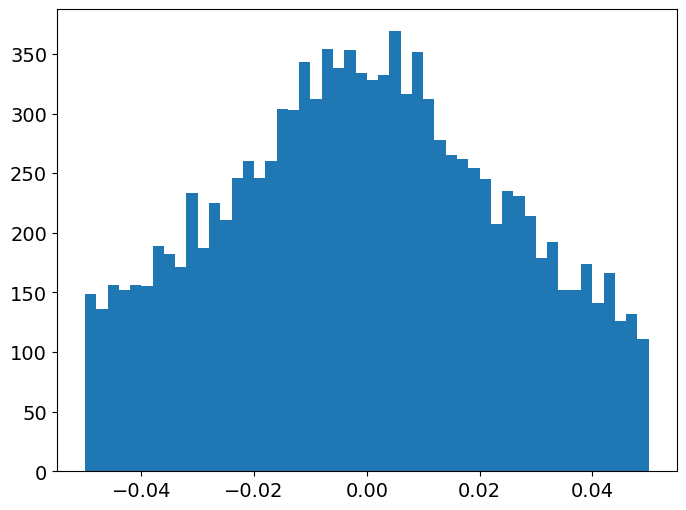

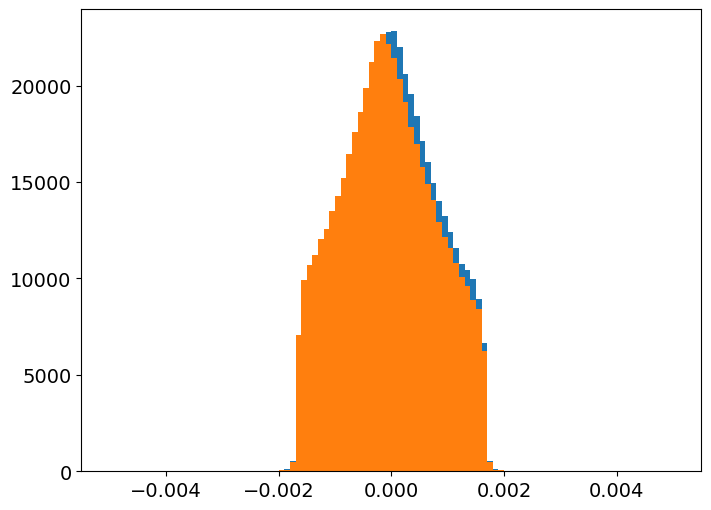

In [98]:
plt.hist(light_simulation.data['ux_lep'],bins=np.linspace(-0.05,0.05,51))
plt.show()
plt.hist(light_simulation.data['uy_lep'],bins=np.linspace(-0.05,0.05,51))
plt.show()

plt.hist(light_simulation.data['ux'],bins=np.linspace(-0.005,0.005,101))
plt.hist(light_simulation.data['uy'],bins=np.linspace(-0.005,0.005,101))
plt.show()